## DFO Nutrient Comparison

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw

import scipy.optimize as scopt

%matplotlib inline

In [2]:
PATH= '/data/eolson/MEOPAR/SS36runs/linkHC201812/'
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2018,12,31)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO()
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,12.0,NaN,None,5.28,mg/m^3,6.6,13.6,umol/L,NaN,NaN,12.0,1982-07-16 01:21:00
1,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,21.5,NaN,None,0.61,mg/m^3,21.2,45.0,umol/L,NaN,NaN,21.5,1982-07-16 01:21:00
2,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,30.5,NaN,None,NaN,mg/m^3,23.5,47.4,umol/L,NaN,NaN,30.5,1982-07-16 01:21:00
3,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,52.3,NaN,None,NaN,mg/m^3,28.0,50.2,umol/L,NaN,NaN,52.3,1982-07-16 01:21:00
4,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,75.4,NaN,None,NaN,mg/m^3,26.5,49.1,umol/L,NaN,NaN,75.4,1982-07-16 01:21:00


In [3]:
df2=df1.loc[(df1.Lat<48.6)&(df1.Lon<-124.5)]
df2.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
11,2008.0,6.0,20.0,11.473056,48.47,-124.547167,2.0,NaN,NaN,None,5.30,mg/m^3,21.3,37.7,umol/L,31.731979,9.648685,1.983125,2008-06-20 11:28:23
12,2008.0,6.0,20.0,11.473056,48.47,-124.547167,4.9,NaN,NaN,None,NaN,mg/m^3,21.3,36.9,umol/L,31.776067,9.409853,4.858622,2008-06-20 11:28:23
13,2008.0,6.0,20.0,11.473056,48.47,-124.547167,9.9,NaN,NaN,None,3.51,mg/m^3,25.0,39.9,umol/L,31.827200,9.083090,9.816280,2008-06-20 11:28:23
14,2008.0,6.0,20.0,11.473056,48.47,-124.547167,19.5,NaN,NaN,None,1.91,mg/m^3,26.8,42.1,umol/L,31.946372,8.948434,19.334645,2008-06-20 11:28:23
15,2008.0,6.0,20.0,11.473056,48.47,-124.547167,30.4,NaN,NaN,None,NaN,mg/m^3,29.4,46.0,umol/L,32.489930,8.362223,30.141419,2008-06-20 11:28:23


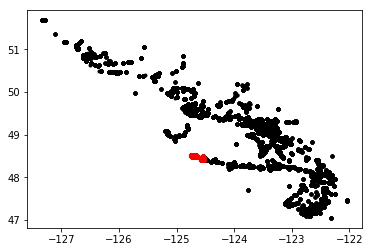

In [4]:
plt.plot(df1.Lon,df1.Lat,'k.')
plt.plot(df2.Lon,df2.Lat,'r.')

In [5]:
data=et.matchData(df2,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

In [6]:
data.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure', 'Depth',
       'Ammonium', 'Ammonium_units', 'Chlorophyll_Extracted',
       'Chlorophyll_Extracted_units', 'N', 'Si', 'Silicate_units', 'AbsSal',
       'ConsT', 'Z', 'dtUTC', 'j', 'i', 'mod_nitrate', 'mod_silicon',
       'mod_ammonium', 'mod_diatoms', 'mod_ciliates', 'mod_flagellates',
       'mod_vosaline', 'mod_votemper'],
      dtype='object')

In [7]:
data['LOmin']=np.zeros(np.shape(data['Lat']))

In [8]:
data['LOmax']=np.zeros(np.shape(data['Lat']))

In [9]:
zex=nc.Dataset('/data/eolson/results/MEOPAR/SS36runs/linkHC201812/05nov15/SalishSea_1d_20151105_20151105_ptrc_T.nc')
zex.variables.keys()

odict_keys(['nav_lat', 'nav_lon', 'bounds_lon', 'bounds_lat', 'area', 'deptht', 'deptht_bounds', 'nitrate', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'ammonium', 'silicon', 'diatoms', 'flagellates', 'ciliates', 'microzooplankton', 'dissolved_organic_nitrogen', 'particulate_organic_nitrogen', 'biogenic_silicon', 'Fraser_tracer', 'mesozooplankton'])

In [10]:
#'/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_y2016m09d26.nc'
for i,r in data.iterrows():
    stencil='/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201712_{}.nc'
    try:
        file=glob.glob(stencil.format(r['dtUTC'].strftime('y%Ym%md%d')))[0]

    except:
        print('file does not exist:  '+stencil.format(r['dtUTC'].strftime('y%Ym%md%d')))
        raise
    k=et._getZInd_bin(r['Z'],zex)
    with nc.Dataset(file) as f:
        nmin=np.min(f.variables['NO3'][0,k,0,:])
        nmax=np.max(f.variables['NO3'][0,k,0,:])
    data.loc[i,['LOmin']]=nmin
    data.loc[i,['LOmax']]=nmax

In [11]:
data.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,...,mod_nitrate,mod_silicon,mod_ammonium,mod_diatoms,mod_ciliates,mod_flagellates,mod_vosaline,mod_votemper,LOmin,LOmax
0,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,1.6,NaN,NaN,None,...,5.142227,13.671011,0.531737,0.624700,0.046742,0.196337,28.772097,11.000047,2.743365,5.084674
1,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,5.9,NaN,NaN,None,...,5.293305,13.937881,0.549040,0.621223,0.048765,0.200093,28.810715,11.014296,3.274726,8.623489
2,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,12.1,NaN,NaN,None,...,6.475900,15.165771,0.599853,0.398532,0.031214,0.117831,29.178440,10.988969,6.013411,13.804135
3,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,21.2,NaN,NaN,None,...,13.461176,27.258038,0.914597,0.247184,0.075716,0.214386,30.565741,10.128565,13.586547,20.030382
4,2015.0,4.0,2.0,15.396111,48.499833,-124.733167,31.0,NaN,NaN,None,...,16.946976,34.126377,1.172577,0.266488,0.143763,0.305166,31.144781,9.624642,15.924139,21.777010


In [12]:
def outside(lo,hi,val):
    if val>hi:
        y=val-hi
    elif val<lo:
        y=val-lo
    else:
        y=0
    return y

In [13]:
data['outside']=[outside(lo,hi,val) for lo,hi,val in zip(data['LOmin'],data['LOmax'],data['mod_nitrate'])]

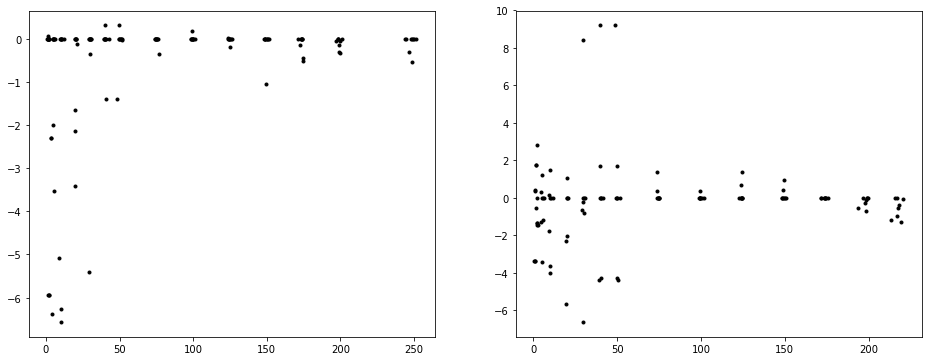

In [14]:
fig,ax=plt.subplots(1,2,figsize=(16,6))
d1=data.loc[data.Lon<-124.6]
d2=data.loc[data.Lon>=-124.6]
ax[0].plot(d1['Z'],d1['outside'],'k.')
ax[1].plot(d2['Z'],d2['outside'],'k.')
d3=data.loc[data['outside']==0]

# Nitrate data comparisons

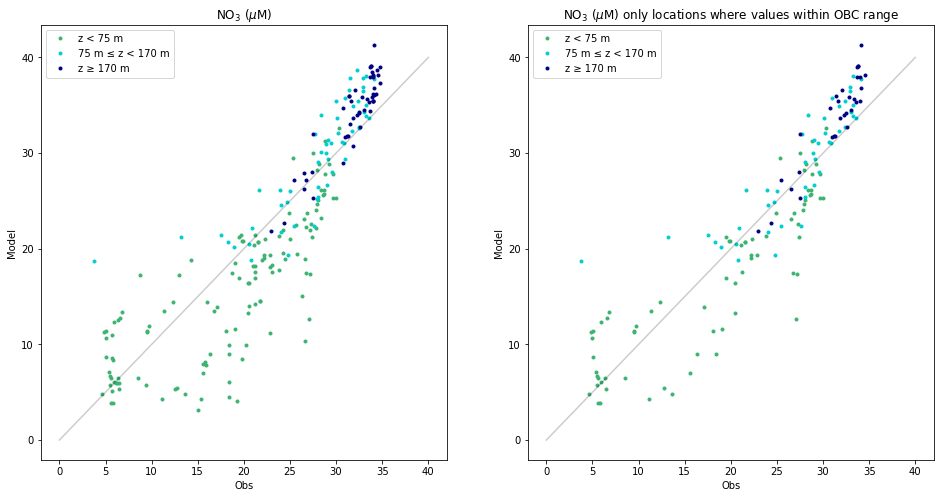

In [15]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ps=et.varvarPlot(ax[0],data,'N','mod_nitrate','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('NO$_3$ ($\mu$M)')
ax[0].plot((0,40),(0,40),'k-',alpha=.2)

ps=et.varvarPlot(ax[1],d3,'N','mod_nitrate','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('NO$_3$ ($\mu$M) only locations where values within OBC range')
ax[1].plot((0,40),(0,40),'k-',alpha=.2)

By Year for Depths < 75


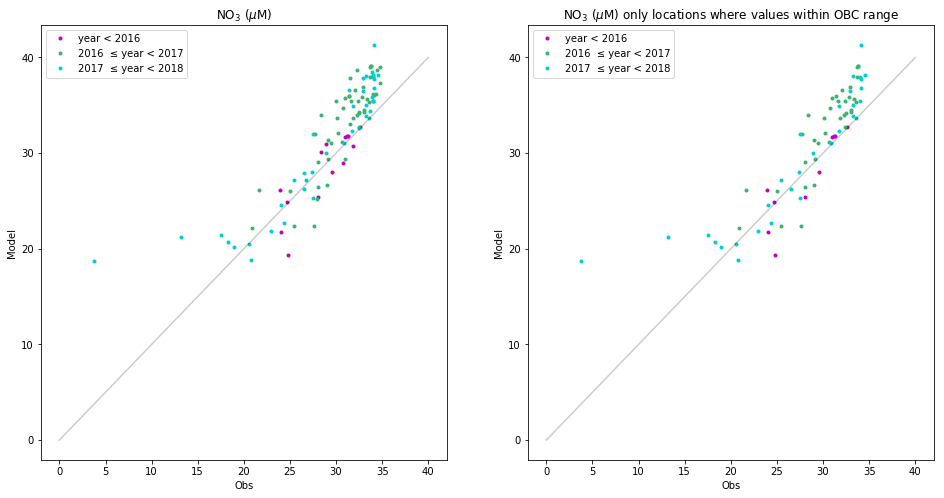

In [16]:
data2=data.loc[data.Z>75]
fig, ax = plt.subplots(1,2,figsize = (16,8))
iax=ax[0]
ps=et.varvarPlot(iax,data2,'N','mod_nitrate','Year',(2016,2017,2018),'year','',('m','mediumseagreen','darkturquoise','navy'))
iax.legend(handles=ps)
iax.set_xlabel('Obs')
iax.set_ylabel('Model')
iax.set_title('NO$_3$ ($\mu$M)')
iax.plot((0,40),(0,40),'k-',alpha=.2)

d32=d3.loc[d3.Z>75]
iax=ax[1]
ps=et.varvarPlot(iax,d32,'N','mod_nitrate','Year',(2016,2017,2018),'year','',('m','mediumseagreen','darkturquoise','navy'))
iax.legend(handles=ps)
iax.set_xlabel('Obs')
iax.set_ylabel('Model')
iax.set_title('NO$_3$ ($\mu$M) only locations where values within OBC range')
iax.plot((0,40),(0,40),'k-',alpha=.2)
print('By Year for Depths < 75')

In [17]:
print('maximum nitrate in obs is:')
np.max(data['N'])

maximum nitrate in obs is:


34.81

In [18]:
def ncor(b,N0):
    s=b[0]
    nmax=b[1]
    xx=np.array([(ii-s) if ii>s else 0 for ii in N0])
    y=N0-xx*xx/(xx+nmax-s)
    return y

In [19]:
def res(b,N0,Nobs):
    return Nobs-ncor(b,N0)

(-10, 20)

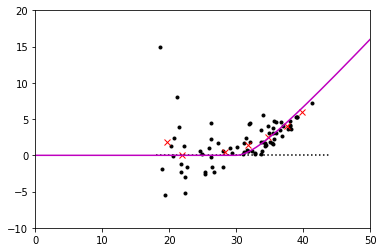

In [20]:
plt.plot(d32['mod_nitrate'],d32['mod_nitrate']-d32['N'],'k.')
iis=np.digitize(d32['mod_nitrate'],np.arange(18,44,3))
dnew=d32.copy()
dnew['iis']=iis
#zs=list()
diffs=list()
nms=list()
for iii in np.unique(iis):
    #zs.append(np.mean(dnew.loc[dnew.iis==iii,['Z']].values))
    nms.append(np.mean(dnew.loc[dnew.iis==iii,['mod_nitrate']].values))
    diffs.append(np.mean(dnew.loc[dnew.iis==iii,['mod_nitrate']].values-dnew.loc[dnew.iis==iii,['N']].values))
plt.plot(np.array(nms),np.array(diffs),'rx')
plt.plot((18,44),(0,0),'k:')

x0=np.arange(0,150,.5)
s=30

plt.plot(x0,res([s,35],x0,x0),'m-')
#plt.plot(x0,y2,'c-')
plt.xlim(0,50)
plt.ylim(-10,20)

`gtol` termination condition is satisfied.
Function evaluations 9, initial cost 8.7395e-01, final cost 9.0740e-02, first-order optimality 1.82e-09.
fit: [25.87963182 46.05019433]


(-10, 20)

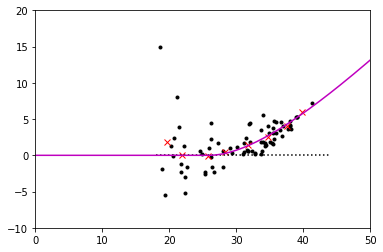

In [21]:
plt.plot(d32['mod_nitrate'],d32['mod_nitrate']-d32['N'],'k.')
dnew=d32.loc[d32.N>=0].copy()
iis=np.digitize(dnew['mod_nitrate'],np.arange(18,44,3))
dnew['iis']=iis
#zs=list()
diffs=list()
nms=list()
obs=list()
for iii in np.unique(iis):
    #zs.append(np.mean(dnew.loc[dnew.iis==iii,['Z']].values))
    nms.append(np.mean(dnew.loc[dnew.iis==iii,['mod_nitrate']].values))
    diffs.append(np.mean(dnew.loc[dnew.iis==iii,['mod_nitrate']].values-dnew.loc[dnew.iis==iii,['N']].values))
    obs.append(np.mean(dnew.loc[dnew.iis==iii,['N']].values))
plt.plot(np.array(nms),np.array(diffs),'rx')
plt.plot((18,44),(0,0),'k:')

ls=scopt.least_squares(res,[30,35],
                args=(np.array(nms[1:]),np.array(obs[1:])),
                        verbose=1,ftol=1e-15)

print('fit:',ls.x)
#print('sum squared error:',np.sum((dfXMPAR['I']-Iest1)**2)/10e6)

x0=np.arange(0,150,.5)
b=ls.x

plt.plot(x0,res(b,x0,x0),'m-')
#plt.plot(x0,y2,'c-')
plt.xlim(0,50)
plt.ylim(-10,20)

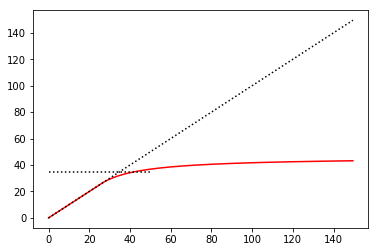

In [22]:
plt.plot(x0,ncor(b,x0),'r-')
plt.plot(x0,x0,'k:')
plt.plot((0,50),(35,35),'k:')

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


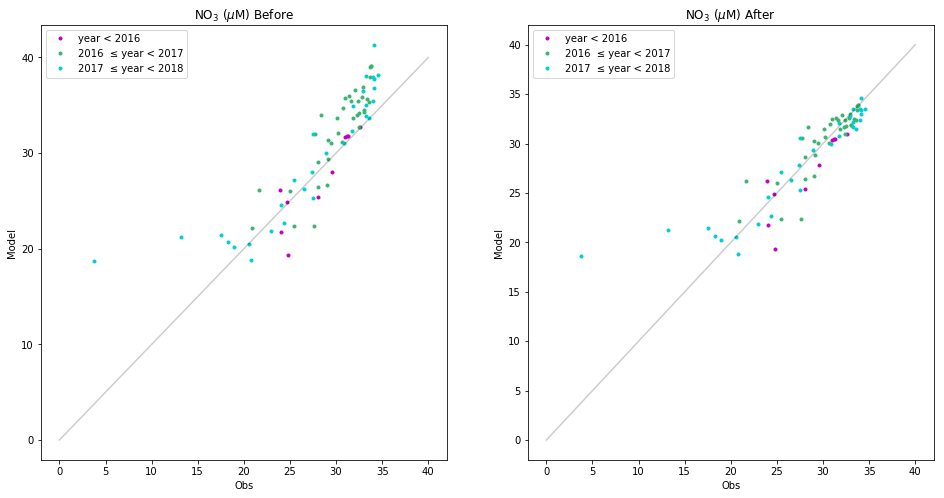

In [23]:
data2=data.loc[data.Z>75]
fig, ax = plt.subplots(1,2,figsize = (16,8))

iax=ax[0]
ps=et.varvarPlot(iax,d32,'N','mod_nitrate','Year',(2016,2017,2018),'year','',('m','mediumseagreen','darkturquoise','navy'))
iax.legend(handles=ps)
iax.set_xlabel('Obs')
iax.set_ylabel('Model')
iax.set_title('NO$_3$ ($\mu$M) Before')
iax.plot((0,40),(0,40),'k-',alpha=.2)

d32['ncor']=ncor(b,d32['mod_nitrate'])
iax=ax[1]
ps=et.varvarPlot(iax,d32,'N','ncor','Year',(2016,2017,2018),'year','',('m','mediumseagreen','darkturquoise','navy'))
iax.legend(handles=ps)
iax.set_xlabel('Obs')
iax.set_ylabel('Model')
iax.set_title('NO$_3$ ($\mu$M) After')
iax.plot((0,40),(0,40),'k-',alpha=.2)

### Si

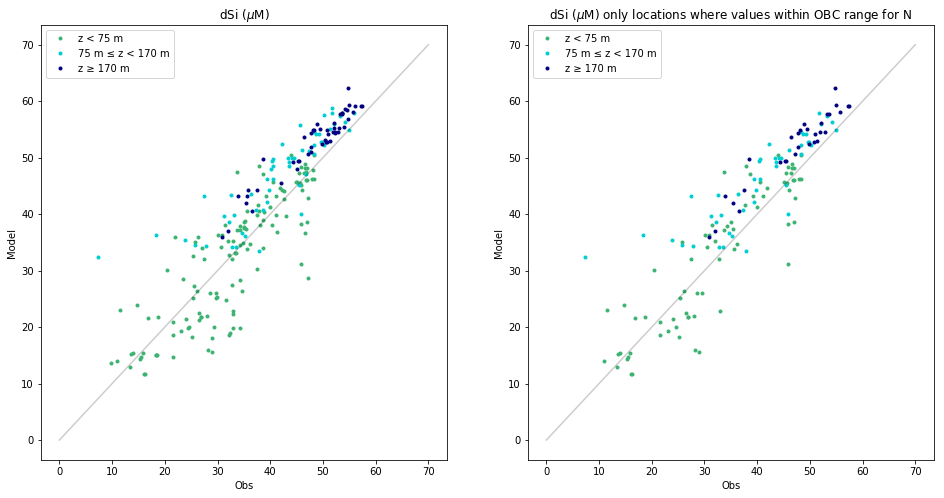

In [24]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ps=et.varvarPlot(ax[0],data,'Si','mod_silicon','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('dSi ($\mu$M)')
ax[0].plot((0,70),(0,70),'k-',alpha=.2)

ps=et.varvarPlot(ax[1],d3,'Si','mod_silicon','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('dSi ($\mu$M) only locations where values within OBC range for N')
ax[1].plot((0,70),(0,70),'k-',alpha=.2)

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Based on Corrected N


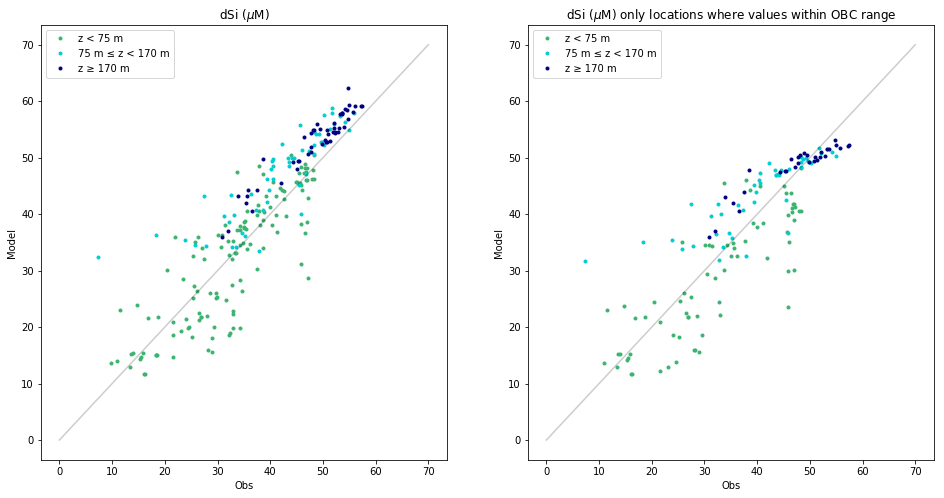

In [25]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ps=et.varvarPlot(ax[0],data,'Si','mod_silicon','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('dSi ($\mu$M)')
ax[0].plot((0,70),(0,70),'k-',alpha=.2)

d3['sicor']=6.46+1.35*ncor(b,d3['mod_nitrate'])
ps=et.varvarPlot(ax[1],d3,'Si','sicor','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('dSi ($\mu$M) only locations where values within OBC range')
ax[1].plot((0,70),(0,70),'k-',alpha=.2)
print('Based on Corrected N')

In [26]:
b

array([25.87963182, 46.05019433])

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Based on Original N


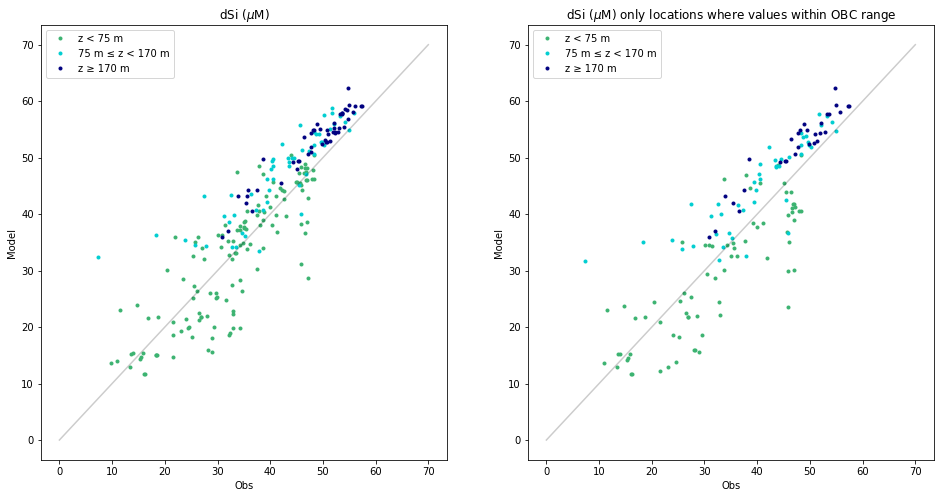

In [27]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ps=et.varvarPlot(ax[0],data,'Si','mod_silicon','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('dSi ($\mu$M)')
ax[0].plot((0,70),(0,70),'k-',alpha=.2)

d3['sicor2']=6.46+1.35*d3['mod_nitrate']
ps=et.varvarPlot(ax[1],d3,'Si','sicor2','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('dSi ($\mu$M) only locations where values within OBC range')
ax[1].plot((0,70),(0,70),'k-',alpha=.2)
print('Based on Original N')

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Based on Original N with correction of -3


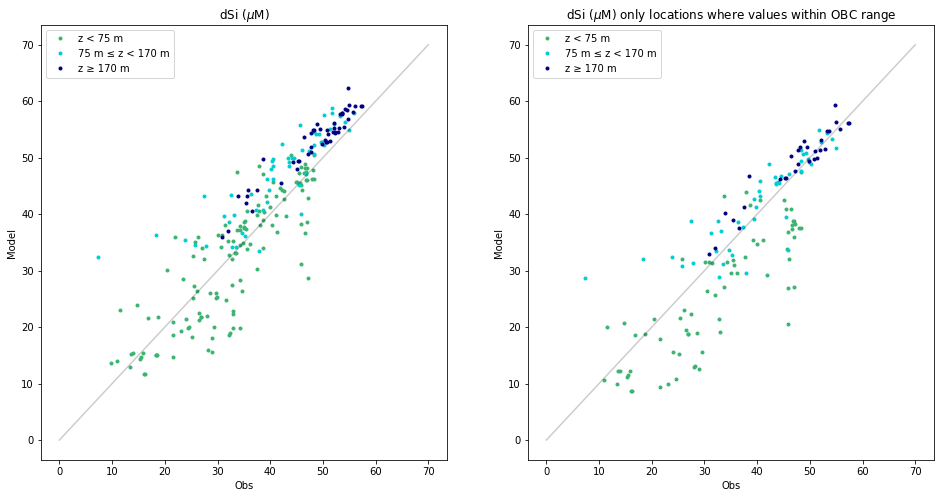

In [28]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ps=et.varvarPlot(ax[0],data,'Si','mod_silicon','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('dSi ($\mu$M)')
ax[0].plot((0,70),(0,70),'k-',alpha=.2)

d3['sicor2']=3.46+1.35*d3['mod_nitrate']
ps=et.varvarPlot(ax[1],d3,'Si','sicor2','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('dSi ($\mu$M) only locations where values within OBC range')
ax[1].plot((0,70),(0,70),'k-',alpha=.2)
print('Based on Original N with correction of -3')

### fit obs si to LiveOcean N:

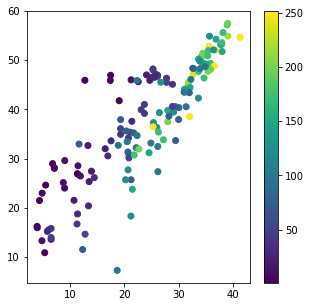

In [34]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(d3['mod_nitrate'],d3['Si'],c=d3['Z'])
fig.colorbar(m)

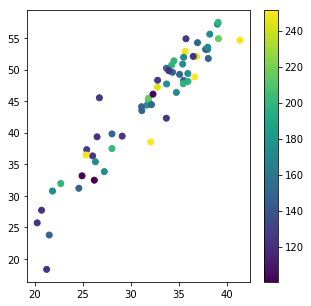

In [36]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(d3.loc[d3.Z>100,['mod_nitrate']],d3.loc[d3.Z>100,['Si']],c=d3.loc[d3.Z>100,['Z']])
fig.colorbar(m)

In [93]:
modN=d3.loc[(d3.Z>100)&(d3.Si>=0),['mod_nitrate']].values[:,0]
obsSi=d3.loc[(d3.Z>100)&(d3.Si>=0),['Si']].values[:,0]
const=np.ones(len(modN))
a=np.vstack([modN,const]).T
m = np.linalg.lstsq(a,obsSi)[0]
print(m)

[ 1.57847519 -5.77099465]


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


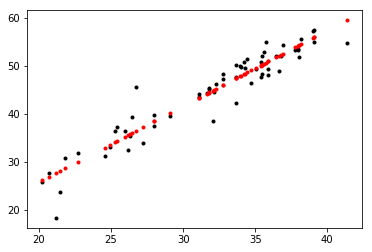

In [94]:
plt.plot(modN,obsSi,'k.')
plt.plot(modN,np.dot(a,m),'r.')

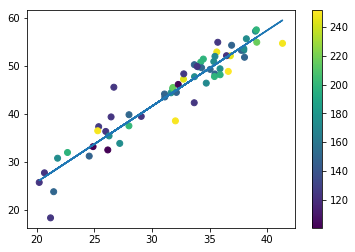

In [99]:
plt.scatter(modN,obsSi,c=d3.loc[(d3.Z>100)&(d3.Si>=0),['Z']].values[:,0])
plt.plot(modN,m[0]*modN+m[1])
plt.colorbar()

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Based on new fit


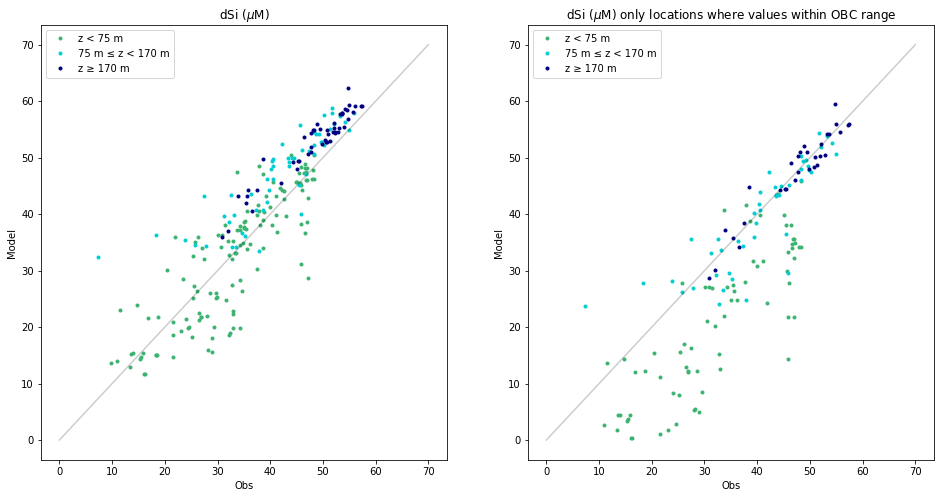

In [103]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ps=et.varvarPlot(ax[0],data,'Si','mod_silicon','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('dSi ($\mu$M)')
ax[0].plot((0,70),(0,70),'k-',alpha=.2)

d3['sicor3']=-5.77+1.58*d3['mod_nitrate']
ps=et.varvarPlot(ax[1],d3,'Si','sicor3','Z',(75,170),'z','m',('mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('dSi ($\mu$M) only locations where values within OBC range')
ax[1].plot((0,70),(0,70),'k-',alpha=.2)
print('Based on new fit')

In [118]:
modN=d3.loc[(d3.Si>=0),['mod_nitrate']].values[:,0]
obsSi=d3.loc[(d3.Si>=0),['Si']].values[:,0]
obsZ=d3.loc[(d3.Si>=0),['mod_vosaline']].values[:,0]
const=np.ones(len(modN))
a=np.vstack([modN,obsZ,const]).T
m = np.linalg.lstsq(a,obsSi)[0]
print(m)

[  1.44914972  -3.41788807 114.3877595 ]


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Based on new fit with z


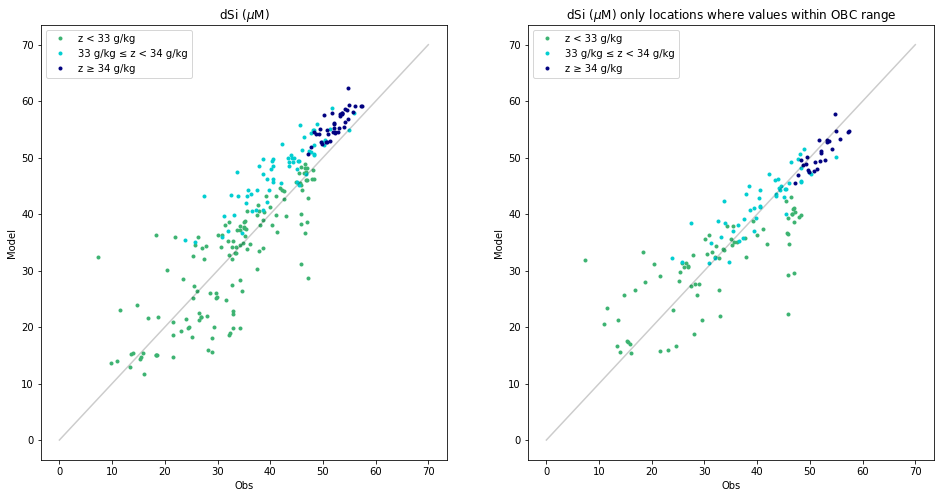

In [120]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ps=et.varvarPlot(ax[0],data,'Si','mod_silicon','AbsSal',(33,34),'z','g/kg',('mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('dSi ($\mu$M)')
ax[0].plot((0,70),(0,70),'k-',alpha=.2)

d3['sicor4']=m[2]+m[1]*d3['AbsSal']+m[0]*d3['mod_nitrate']
ps=et.varvarPlot(ax[1],d3,'Si','sicor4','AbsSal',(33,34),'z','g/kg',('mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('dSi ($\mu$M) only locations where values within OBC range')
ax[1].plot((0,70),(0,70),'k-',alpha=.2)
print('Based on new fit with z')

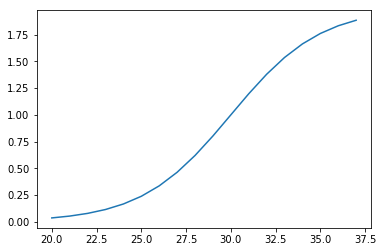

In [127]:
x=np.arange(20,38)
plt.plot(x,np.tanh((x-30)*.2)+1)

In [149]:
def estSi(b,N,SA):
    x0=b[0]
    x1=b[1]
    x2=b[2]
    tsa=b[3]
    sigma=b[4]
    Si=x0+x1*N+x2*np.tanh(sigma*(SA-tsa))
    return np.array([ii if ii>0 else 0.0 for ii in Si]).flatten()

In [150]:
def resEstSi(b,N,SA,obsSi):
    return estSi(b,N,SA)-obsSi

In [191]:
res=scopt.least_squares(resEstSi,[3,1.5,3,33,.8],bounds=([-np.inf, 0,-15,31,.01],[np.inf,5,5,34,10]),
                        args=(d3.loc[(d3.Si>=0),['mod_nitrate']].values[:,0],d3.loc[(d3.Si>=0),['mod_vosaline']].values[:,0],d3.loc[(d3.Si>=0),['Si']].values[:,0]),
                        verbose=1,ftol=1e-15)

print('fit:',res.x)
#print('sum squared error:',np.sum((dfXMPAR['I']-Iest2)**2)/10e6)

`xtol` termination condition is satisfied.
Function evaluations 33, initial cost 6.1683e+03, final cost 1.9835e+03, first-order optimality 1.14e-04.
fit: [ 1.75583269  1.55645062 -7.33139567 32.49292141  1.63114883]


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Based on new fit with z


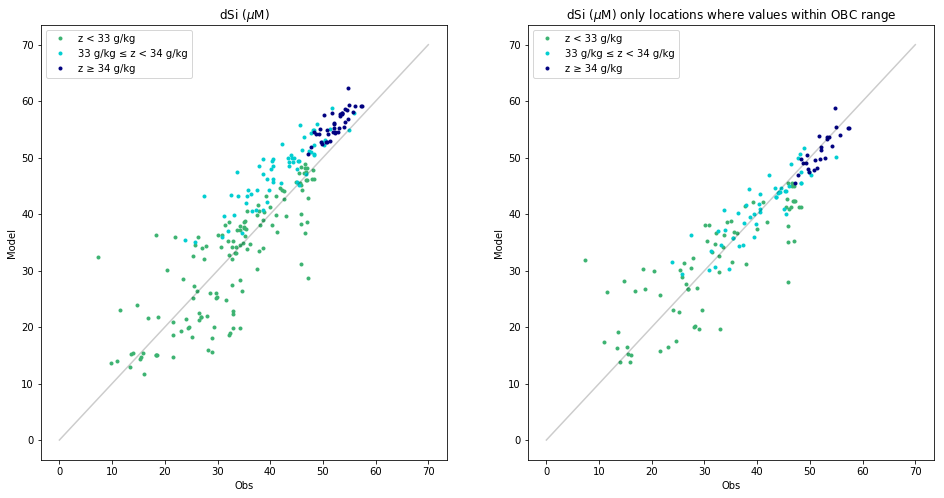

In [192]:
fig, ax = plt.subplots(1,2,figsize = (16,8))
ps=et.varvarPlot(ax[0],data,'Si','mod_silicon','AbsSal',(33,34),'z','g/kg',('mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('dSi ($\mu$M)')
ax[0].plot((0,70),(0,70),'k-',alpha=.2)

d3['sicor5']= estSi(res.x,d3['mod_nitrate'],d3['mod_vosaline'])
ps=et.varvarPlot(ax[1],d3,'Si','sicor5','AbsSal',(33,34),'z','g/kg',('mediumseagreen','darkturquoise','navy'))
#ps=et.varvarPlot(ax[1],d3,'Si','sicor4','AbsSal',(33,34),'z','g/kg',('red','orange','yellow'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('dSi ($\mu$M) only locations where values within OBC range')
ax[1].plot((0,70),(0,70),'k-',alpha=.2)
print('Based on new fit with z')

In [193]:
[nn,ss]=np.meshgrid(np.arange(0,38,.1),np.arange(0,36,.1))

In [194]:
si=estSi(res.x,nn.flatten(),ss.flatten())

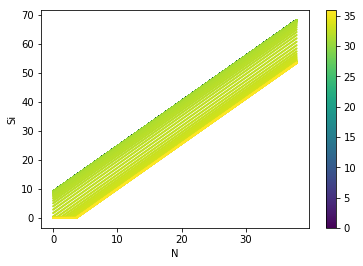

In [195]:
plt.scatter(nn.flatten(),si,c=ss.flatten(),s=1)
plt.colorbar()
plt.xlabel('N')
plt.ylabel('Si')